<h1><center><font size="25">Forecasting with LSTM models</font></center></h1>

<center><b>Joaquín Amat Rodrigo, Javier Escobar Ortiz</b></center>

<center><i>September, 2023</i></center>

**More about forecasting**

+ [Introduction to forecasting with skforecast](https://cienciadedatos.net/documentos/py27-time-series-forecasting-python-scikitlearn.html)
+ [Forecasting time series with gradient boosting: Skforecast, XGBoost, LightGBM and CatBoost](https://www.cienciadedatos.net/documentos/py39-forecasting-time-series-with-skforecast-xgboost-lightgbm-catboost.html)
+ [Forecasting electricity demand with Python](https://www.cienciadedatos.net/documentos/py29-forecasting-electricity-power-demand-python.html)
+ [Forecasting web traffic with machine learning and Python](https://www.cienciadedatos.net/documentos/py37-forecasting-web-traffic-machine-learning.html)
+ [Bitcoin price prediction with Python, when the past does not repeat itself](https://www.cienciadedatos.net/documentos/py41-forecasting-cryptocurrency-bitcoin-machine-learning-python.html)
+ [Prediction intervals in forecasting models](https://www.cienciadedatos.net/documentos/py42-forecasting-prediction-intervals-machine-learning.html)
+ [Intermittent demand forecasting with skforecast](https://www.cienciadedatos.net/documentos/py48-intermittent-demand-forecasting)

<p align="center"><img src='https://github.com/JoaquinAmatRodrigo/skforecast/raw/master/docs/img/banner-landing-page-skforecast.png'style="width: 600px"></p>

## Introdución


<p align="center"><img src='lstm1.png'style="width: 600px"></p>

## Librerías

In [14]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
sys.path.insert(1, str(Path.cwd().parent))
str(Path.cwd().parent)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'/Users/fernandocarazo/Documents/git-repos/skforecast'

In [15]:
#!pip install tensorflow
#!pip install torch -f https://download.pytorch.org/whl/torch_stable.html
#!pip install pytorch-forecasting

In [16]:
# Data processing
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Modelling
# ==============================================================================
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.ForecasterRnn import ForecasterRnn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Dense, Input, Reshape, LSTM
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adagrad, Adadelta, Adamax, Nadam
from tensorflow.keras.losses import MeanSquaredError

from tensorflow.keras.callbacks import EarlyStopping



In [17]:
from skforecast.utils.rnn import create_model_lstm

## Datos

In [18]:
# ---------------------------------------------------------------------------- #
#                               Downloading data                               #
# ---------------------------------------------------------------------------- #

url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/Estadistica-machine-'
       'learning-python/master/data/bike_sharing_dataset_clean.csv')
data = pd.read_csv(url)
data['date_time'] = pd.to_datetime(data['date_time'], format='%Y-%m-%d %H:%M:%S')
data = data.set_index('date_time')
print(data.index.to_series().diff().dt.total_seconds().value_counts())
data = data.asfreq('H')
data = data.sort_index()
data = data.drop(columns=['workingday', "weather"])
data.head()

date_time
3600.0    17543
Name: count, dtype: int64


,holiday,temp,atemp,hum,windspeed,users,month,hour,weekday
date_time,,,,,,,,,
2011-01-01 00:00:00,0.0,9.84,14.395,81.0,0.0,16.0,1,0,5
2011-01-01 01:00:00,0.0,9.02,13.635,80.0,0.0,40.0,1,1,5
2011-01-01 02:00:00,0.0,9.02,13.635,80.0,0.0,32.0,1,2,5
2011-01-01 03:00:00,0.0,9.84,14.395,75.0,0.0,13.0,1,3,5
2011-01-01 04:00:00,0.0,9.84,14.395,75.0,0.0,1.0,1,4,5


In [19]:
# ---------------------------------------------------------------------------- #
#                          Split train-validation-test                         #
# ---------------------------------------------------------------------------- #

end_train = '2012-03-31 23:59:00'
end_validation = '2012-08-31 23:59:00'
data_train = data.loc[: end_train, :]
data_val   = data.loc[end_train:end_validation, :]
data_test  = data.loc[end_validation:, :]

print(f"Dates train      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Dates validacion : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Dates test       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Dates train      : 2011-01-01 00:00:00 --- 2012-03-31 23:00:00  (n=10944)
Dates validacion : 2012-04-01 00:00:00 --- 2012-08-31 23:00:00  (n=3672)
Dates test       : 2012-09-01 00:00:00 --- 2012-12-31 23:00:00  (n=2928)


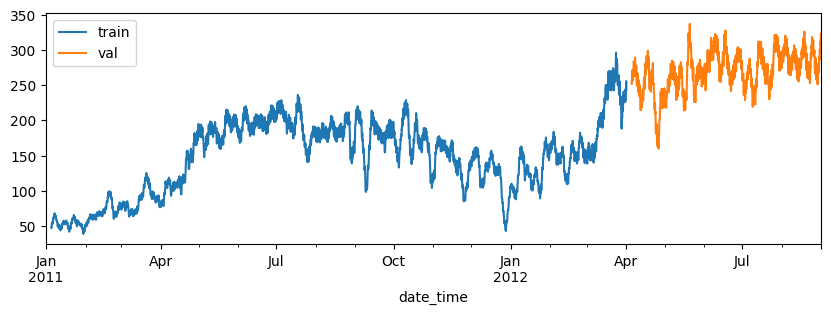

In [20]:
import seaborn as sns
# ----------------------------------- Users ---------------------------------- #
fig, ax = plt.subplots(figsize=(10,3))
data_train[["users"]].rolling(100).mean().plot(ax=ax, label="train")
data_val[["users"]].rolling(100).mean().plot(ax=ax, label="val")
ax.legend(["train", "val"]) 

## Modelo LSTM con tensorflow-keras

https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

https://www.tensorflow.org/tutorials/structured_data/time_series


We are working with a univariate series, so the number of features is one, for one variable.

The number of time steps as input is the number of lags used as predictors.

We almost always have multiple samples, therefore, the model will expect the input component of training data to have the dimensions or shape: [samples, timesteps, features]

# Multi-series, multi-step

In [79]:
levels = ["users", "temp", "hum"] # , 
lags=2
steps=5

# llevar el compile al create model

model = create_model_lstm(
    series=data_train,
    lags=lags,
    steps=steps,
    levels = levels,
    lstm_unit=100,
    dense_units=[128, 64],
    optimizer=Adam(learning_rate=0.01), 
    loss= MeanSquaredError()
)
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 2, 9)]            0         
                                                                 
 lstm_5 (LSTM)               (None, 100)               44000     
                                                                 
 dense_15 (Dense)            (None, 128)               12928     
                                                                 
 dense_16 (Dense)            (None, 64)                8256      
                                                                 
 dense_17 (Dense)            (None, 15)                975       
                                                                 
 reshape_5 (Reshape)         (None, 5, 3)              0         
                                                                 
Total params: 66159 (258.43 KB)
Trainable params: 66159 (25

In [82]:
forecaster = ForecasterRnn(
    regressor=model, 
    levels=levels, 
    transformer_series=MinMaxScaler(),
    fit_kwargs={
        "epochs":100,
        "batch_size":128,
        "callbacks":[EarlyStopping(monitor='val_loss', patience=10)],
        "series_val":data_val,
    },
)


In [83]:
forecaster.fit(
    data_train)

Epoch 1/100
86/86 [==============================] - 5s 14ms/step - loss: 0.0262 - val_loss: 0.0282
Epoch 2/100
86/86 [==============================] - 1s 8ms/step - loss: 0.0089 - val_loss: 0.0212
Epoch 3/100
86/86 [==============================] - 1s 9ms/step - loss: 0.0074 - val_loss: 0.0183
Epoch 4/100
86/86 [==============================] - 1s 10ms/step - loss: 0.0068 - val_loss: 0.0179
Epoch 5/100
86/86 [==============================] - ETA: 0s - loss: 0.0061

KeyboardInterrupt: 

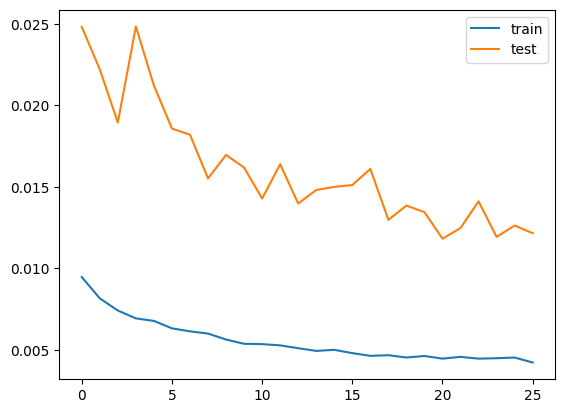

In [78]:
# ---------------------------------------------------------------------------- #
#                                 plot history                                 #
# ---------------------------------------------------------------------------- #

def plot_history(history):
    plt.plot(history['loss'][1:], label='train')
    plt.plot(history['val_loss'][1:], label='test')
    plt.legend()
    plt.show()
    
plot_history(forecaster.regressor.history.history)
    

In [48]:
model.evaluate(X_test, y_test)

90/90 [==============================] - 1s 5ms/step - loss: 0.0079


0.007896093651652336

In [57]:
predictions = model.predict(X_test[:2])

1/1 [==============================] - 0s 202ms/step


In [61]:
forecaster.transformer_series.inverse_transform(predictions)

ValueError: Found array with dim 3. None expected <= 2.

In [59]:
y_test[:2]

array([[[0.07377049],
        [0.08504098],
        [0.0420082 ],
        [0.02151639],
        [0.01127049]],

       [[0.08504098],
        [0.0420082 ],
        [0.02151639],
        [0.01127049],
        [0.01434426]]])

In [60]:
# Prediction error (mean absolute error) sklearn
# ==============================================================================
mae = mean_absolute_error(data_test.loc[predictions.index, 'users'], predictions)
print(f"Test MAE: {mae}")

AttributeError: 'numpy.ndarray' object has no attribute 'index'

In [ ]:
predictions

array([[0.1527963 , 0.15284579, 0.15356408, ..., 0.15300936, 0.15304217,
        0.15304947],
       [0.1527963 , 0.15284579, 0.15356408, ..., 0.15300936, 0.15304217,
        0.15304947],
       [0.1527963 , 0.15284579, 0.15356408, ..., 0.15300936, 0.15304217,
        0.15304947],
       ...,
       [0.1527963 , 0.15284579, 0.15356408, ..., 0.15300936, 0.15304217,
        0.15304947],
       [0.1527963 , 0.15284579, 0.15356408, ..., 0.15300936, 0.15304217,
        0.15304947],
       [0.1527963 , 0.15284579, 0.15356408, ..., 0.15300936, 0.15304217,
        0.15304947]], dtype=float32)

## Información de sesión

In [ ]:
import session_info
session_info.show(html=False)

-----
keras               2.13.1
matplotlib          3.7.1
numpy               1.24.3
pandas              1.5.3
session_info        1.0.0
skforecast          0.8.1
sklearn             1.3.0
tensorflow          2.13.0
-----
IPython             8.12.0
jupyter_client      8.1.0
jupyter_core        5.3.0
-----
Python 3.10.10 | packaged by Anaconda, Inc. | (main, Mar 21 2023, 18:39:17) [MSC v.1916 64 bit (AMD64)]
Windows-10-10.0.19045-SP0
-----
Session information updated at 2023-08-30 22:01


# Dev

In [12]:
# Libraries
# ==============================================================================
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import grid_search_forecaster

/Users/fernandocarazo/opt/miniconda3/envs/skforecast_10_py11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Train dates : 1991-07-01 00:00:00 --- 2005-06-01 00:00:00  (n=168)
Test dates  : 2005-07-01 00:00:00 --- 2008-06-01 00:00:00  (n=36)


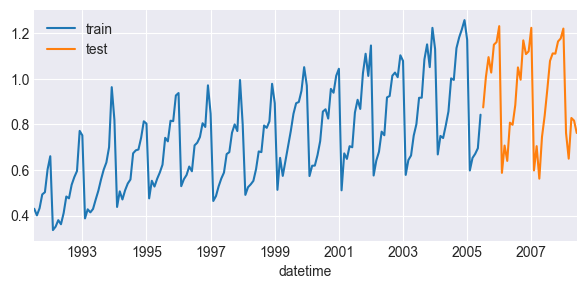

In [13]:
# Download data
# ==============================================================================
url = (
    'https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/'
    'data/h2o.csv'
)
data = pd.read_csv(url, sep=',', header=0, names=['y', 'datetime'])

# Data preprocessing
# ==============================================================================
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d')
data = data.set_index('datetime')
data = data.asfreq('MS')
data = data['y']
data = data.sort_index()

# Data partition train-test
# ==============================================================================
end_train = '2005-06-01 23:59:00'
print(
    f"Train dates : {data.index.min()} --- {data.loc[:end_train].index.max()}  " 
    f"(n={len(data.loc[:end_train])})")
print(
    f"Test dates  : {data.loc[end_train:].index.min()} --- {data.index.max()}  "
    f"(n={len(data.loc[end_train:])})")

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:].plot(ax=ax, label='test')
ax.legend();

In [14]:
# Create and fit a recursive multi-step forecaster (ForecasterAutoreg)
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 15
             )

forecaster.fit(y=data.loc[:end_train])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] 
Transformer for y: None 
Transformer for exog: None 
Window size: 15 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1991-07-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2023-09-27 23:09:38 
Last fit date: 2023-09-27 23:09:38 
Skforecast

In [15]:
# Predict
# ==============================================================================
predictions = forecaster.predict(steps=len(data.loc[end_train:]))
predictions.head(3)

2005-07-01    0.921840
2005-08-01    0.954921
2005-09-01    1.101716
Freq: MS, Name: pred, dtype: float64

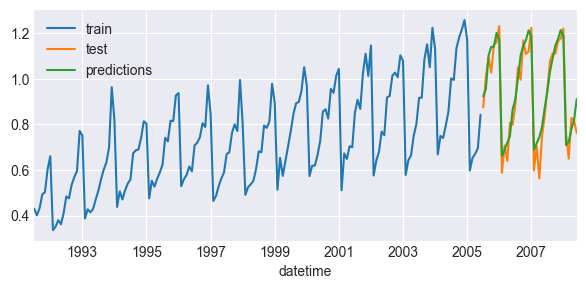

In [16]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

## Bibliografía
<br>

Linear Models with R by Julian J.Faraway [libro](https://www.amazon.es/gp/product/1439887330/ref=as_li_qf_asin_il_tl?ie=UTF8&tag=cienciadedato-21&creative=24630&linkCode=as2&creativeASIN=1439887330&linkId=e9ca62e854567fb3f9d0ea044f084b11)

OpenIntro Statistics: Fourth Edition by David Diez, Mine Çetinkaya-Rundel, Christopher Barr [libro](https://www.amazon.es/gp/product/1943450072/ref=as_li_qf_asin_il_tl?ie=UTF8&tag=cienciadedato-21&creative=24630&linkCode=as2&creativeASIN=1943450072&linkId=a8b49fab17a559d33901ee804a9b5737)

Introduction to Machine Learning with Python: A Guide for Data Scientists [libro](https://www.amazon.es/gp/product/1449369413/ref=as_li_qf_asin_il_tl?ie=UTF8&tag=cienciadedato-21&creative=24630&linkCode=as2&creativeASIN=1449369413&linkId=e07f892d9e2c458e8144303901ea9580)

Points of Significance: Association, correlation and causation. Naomi Altman & Martin Krzywinski Nature Methods

https://en.wikipedia.org/wiki/Co



In [ ]:
%%html
<style>
.text_cell_render p {
    text-align: justify;
    font-family: 'Open Sans','Helvetica Neue',Helvetica,Arial,sans-serif;
    line-height: 1.5;
    font-weight: 400;
    text-shadow: none;
    color: #333333;
    text-rendering: optimizeLegibility;
    letter-spacing: +0.1px;
    margin-bottom: 1.15rem;
    font-size: 1.15em
}

div.admonition.note {
    text-align: justify;
    font-family: 'Open Sans','Helvetica Neue',Helvetica,Arial,sans-serif;
    line-height: 1.5;
    font-weight: 400;
    text-shadow: none;
    color: #333333;
    text-rendering: optimizeLegibility;
    letter-spacing: +0.1px;
    margin-bottom: 1.15rem;
    font-size: 15px;
}


#notebook-container {
    background-color: #fcfcfc;
}

div.inner_cell {
    margin-right: 5%;
}

.output_png {
        display: table-cell;
        text-align: center;
        vertical-align: middle;
}

.rendered_html code {
    background-color: #f2f2f2;
    font-family: monospace;
    color: #a20505;
    font-size: 15px;
    padding: 1px 1px;
    border: solid;
    border-color: darkgray;
    border-width: thin;
}

.rendered_html h1 {
    padding-top: 50px;
}

.rendered_html h2 {
    font-size: 30px;
    margin-top: 0;
    font-size: 2.488em;
}

.rendered_html h3 {
    font-size: 25px;
}

.rendered_html h4 {
    font-size: 20px;
}

</style>

**¿Cómo citar este documento?**

<p style="text-align:left"><font size="3" color="#555">
TITULO DEL DOCUMENTO by AUTOR, available under a Attribution 4.0 International (CC BY 4.0) at https://www.cienciadedatos.net/documentos/pystats05-correlacion-lineal-python.html

    
</font></p>

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons Licence" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br />This work by AUTOR is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.